1. Provide options which dataset/forest to load
2. Precompute maps and cable roads
3. Set A-Value, slope, etc.
4. Provide pre-computed optimized results
5. Editor
   - top layout
   - Pareto frontier
   - Current layout properties
6. Export? to exact positions of tree


In [1]:
# Package Imports
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon, Point
from shapely.affinity import rotate, scale

from importlib import reload

# to load the interactive plotting version
# %matplotlib widget
# or regular
# %matplotlib inline
# %gui qt

# Importing my modules
from src.main import (
    data_loading,
    geometry_operations,
    geometry_utilities,
    cable_road_computation,
    mechanical_computations,
)

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (None)/charset_normalizer (2.1.0) doesn't match a supported version!
  warnings.warn(


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
data_to_load = 1
tree_df, forest_area_gdf, height_df = data_loading.load_bestand_and_forest(data_to_load)

In [73]:
# clean up the data
tree_df.dropna(inplace=True)
tree_df = tree_df[tree_df["h"] > 0]
tree_df = tree_df[tree_df["crownVolume"].astype(int) > 0]
# tree_df.drop(columns=["tile", "scanID", "id"], inplace=True)
tree_df.reset_index(drop=True, inplace=True)

In [74]:
# # recreate the height and diameter series
# tree_df["height_series"] = [list(range(3, int(h))) for h in tree_df["h"]]

durchmesser_csv = pd.read_csv("03_Data/Resources_Organized/durchmesser.csv")
durchmesser_csv = durchmesser_csv[durchmesser_csv.hoehe % 1 == 0]

kes = tree_gdf.id.unique()
id_dict = {}
dm_dict = {}
for ke in kes:
    id_dict[ke] = durchmesser_csv[durchmesser_csv["tree.id"] == ke]["hoehe"].to_list()
    dm_dict[ke] = durchmesser_csv[durchmesser_csv["tree.id"] == ke][
        "durchmesser"
    ].to_list()

tree_df["height_series"] = tree_df["id"].map(id_dict)
tree_df["diameter_series"] = tree_df["id"].map(dm_dict)

In [116]:
# ML approach to learn the diameter function from Christophs data
features = ["BHD", "Ges.h", "hoehe"]
target = "durchmesser"

locs = 35
# # load the data
X = durchmesser_csv[features].iloc[0:locs]
Y = durchmesser_csv[target].iloc[0:locs]

# # split the data
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
# # train the model

In [147]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=60))
clf.fit(X, Y)

# # predict the test data
y_pred = clf.predict(X)

13.396065991181738


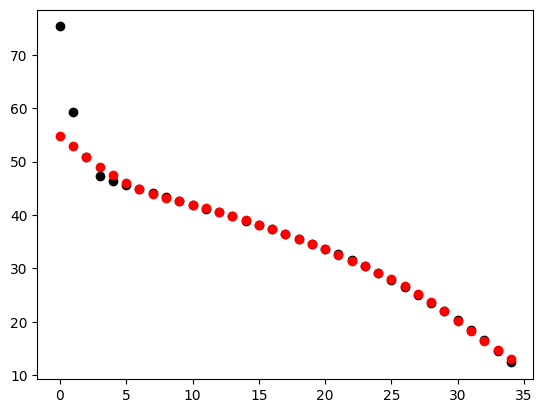

In [148]:
# # evaluate the model
from sklearn.metrics import mean_squared_error

print(mean_squared_error(Y, y_pred))
# X_sorted = X_test.sort_values(by="hoehe")
# #plot the results
# plt.scatter(X_sorted["hoehe"].iloc[0:50], y_train[0:50])
# # plt.hold('on')
# plt.plot(X_sorted["hoehe"].iloc[0:50], y_pred[0:50], color='navy', label='RBF model')
plt.scatter(X["hoehe"], Y, color="black")
plt.scatter(X["hoehe"], y_pred, color="red")
# plt.plot(X_train["hoehe"],  y_poly)

In [221]:
import numpy as np

x_id = durchmesser_csv["tree.id"].unique()
targets = {}
for id in x_id:
    this_group = durchmesser_csv[durchmesser_csv["tree.id"] == id]["durchmesser"].values
    targets[id] = this_group

# create an array with the corresponding bhd and tree id for each tree id
X = [
    durchmesser_csv.loc[durchmesser_csv["tree.id"] == key, ["BHD", "Ges.h"]]
    .iloc[0]
    .values
    for key in targets.keys()
]
X = np.array(X)


# find the max height
max_height = int(max(durchmesser_csv["hoehe"].unique())) + 1
# create an empty ndarray of zeros
Y = np.zeros((len(targets.keys()), max_height))
# fill the array with the corresponding series
for i, key in enumerate(targets.keys()):
    this_group = targets[key]
    Y[i, 0 : len(this_group)] = this_group

# split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

# train a neural network
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(max_iter=2000, hidden_layer_sizes=(100, 100, 100), random_state=42)
clf.fit(X_train, y_train)

# predict the test data
y_pred = clf.predict(X_test)

# evaluate the model
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, y_pred))

# X_ts = [durchmesser_csv[durchmesser_csv["tree.id"] == x]["durchmesser"] for x in x_id]

# X_ts = durchmesser_csv[features].iloc[locs : locs + 30]
# Y_ts = durchmesser_csv[target].iloc[locs : locs + 30]
# y_pred = clf.predict(X_diff)
# plt.scatter(X_diff["hoehe"], Y_diff, color="black")
# plt.scatter(X_diff["hoehe"], y_pred, color="red")

0.9494560719006424


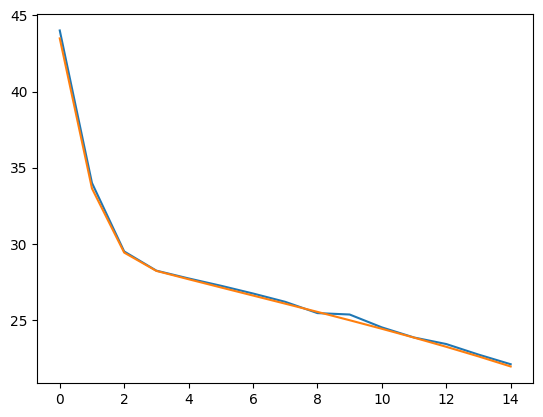

In [226]:
plt.plot(y_pred[4][0:15])
plt.plot(y_test[4][0:15])

In [229]:
tree_df.columns

Index(['x', 'y', 'z', 'id', 'BHD', 'h', 'crownLength', 'crownArea',
       'crownVolume', 'crownDiameter', 'height_series', 'diameter_series',
       'max_supported_force_series', 'max_holding_force'],
      dtype='object')

In [241]:
# so this works okay, need to predict all bestands now
# Y_new = np.zeros((len(tree_df), max_height))
# # fill the array with the corresponding series
# for row in tree_df.iterrows():
#     this_pred = clf.predict
#     Y[i, 0 : len(this_group)] = this_group
a = clf.predict(tree_df[["BHD", "h"]].values)

In [248]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier


# custom metric
def DTW(a, b):
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1, 1), b.reshape(-1, 1))
    cumdist = np.matrix(np.ones((an + 1, bn + 1)) * np.inf)
    cumdist[0, 0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min(
                [cumdist[ai, bi + 1], cumdist[ai + 1, bi], cumdist[ai, bi]]
            )
            cumdist[ai + 1, bi + 1] = pointwise_distance[ai, bi] + minimum_cost

    return cumdist[an, bn]


knns = KNeighborsClassifier(metric=DTW).fit(X, Y)
# kmeans = KNeighborsClassifier(metric=DTW).fit(Y)

ValueError: Unknown label type: 'continuous-multioutput'

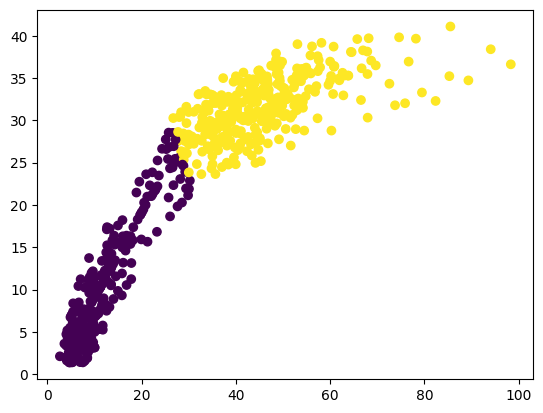

In [244]:
# # plot the kmeans results
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap="viridis")

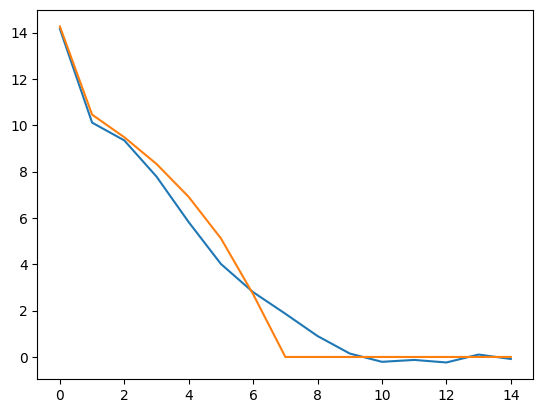

In [253]:
to_plot = 3
plt.plot(y_pred[to_plot][0:15])
plt.plot(y_test[to_plot][0:15])

In [249]:
from tslearn.clustering import TimeSeriesKMeans

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [75]:
# get the euler forces
list_of_euler_max_force_lists = []
for index, row in tree_df.iterrows():
    temp_list = [
        mechanical_computations.euler_knicklast(bhd, height)
        for bhd, height in zip(row["diameter_series"], row["height_series"])
    ]
    list_of_euler_max_force_lists.append(temp_list)

tree_df["max_supported_force_series"] = list_of_euler_max_force_lists


tree_df["max_holding_force"] = (((tree_gdf["BHD"] * 0.1) ** 2) / 3) * 10000

In [76]:
tree_df

,x,y,z,id,BHD,h,crownLength,crownArea,crownVolume,crownDiameter,height_series,diameter_series,max_supported_force_series,max_holding_force
0,-4.087702,13.812045,-4.793,1.0,37.026019,28.51,"22,81","25,2",47.0,6,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[75.3285252060416, 59.2357212453479, 50.810257...","[24959017.529930785, 9543866.365885176, 129162...",9041.459324
1,-72.886940,51.259958,-11.169,2.0,43.708216,27.08,"21,18","44,3",92.7,"7,8","[0.0, 1.0, 2.0, 3.0]","[5.17530099308459, 4.75298477202177, 3.2428768...","[556.0733471775088, 395.59912126499376, 21.431...",37451.395877
2,-69.267941,72.119508,-18.080,3.0,36.617772,30.12,"24,42","44,8",83.3,8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[46.8504987923709, 36.4729261214776, 31.775120...","[3734620.721509984, 1371740.7949710337, 197550...",2790.798207
3,-51.388423,76.299677,-22.043,4.0,15.236598,31.80,"28,6","16,9",28.6,"4,9","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[43.2279489877914, 33.8089756227105, 29.540885...","[2706750.015506462, 1012785.9686439564, 147578...",26504.617612
4,-1.004869,80.451350,-27.953,6.0,39.828429,27.51,"23,46","30,8",49.6,"6,9","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[49.6525908411182, 37.5157809795753, 32.823612...","[4711479.277513838, 1535485.0548590315, 224944...",25287.315740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,56.698030,-13.498930,1.492,378.0,32.540000,31.18,"22,03","21,9",33.8,"5,6","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[24.5584154982255, 17.4878367645024, 16.550812...","[281962.269831994, 72499.32949271392, 14541.42...",2027.980191
282,54.337650,-19.167180,3.022,380.0,60.780000,40.78,"25,13","26,6",36.2,"6,3","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[58.1869035968253, 43.9293594284743, 38.175859...","[8885678.885141028, 2886749.5628835335, 411609...",1233.302183
283,61.541710,-41.923750,15.977,386.0,30.300000,28.47,"27,32","49,5",65.9,"8,6","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[51.2060964475487, 38.0865288243451, 33.473539...","[5329375.318423416, 1631079.7637492241, 243296...",16068.263223
284,57.406860,-45.251310,16.073,387.0,58.020000,25.14,"17,44","48,2",40.3,"8,5","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[74.472996186051, 57.5285745674423, 49.3702663...","[23844319.550379198, 8490320.40678441, 1151307...",17519.321399


In [53]:
tree_df.to_csv(
    f"03_Data/Resources_Organized/Dataframes_Processed/Bestand_{data_to_load}.csv"
)
height_df.to_csv(
    f"03_Data/Resources_Organized/Dataframes_Processed/Height_{data_to_load}.csv"
)

In [57]:
tree_gdf, height_gdf = data_loading.load_processed_gdfs(data_to_load)

KeyError: 'diameter_series'